In [1]:
import sys 
sys.path.append('E:/xinlib')
import xcv
from xcv import XCV

from mxnet import gluon, nd, autograd, image
from mxnet.gluon import nn
from gluoncv.model_zoo import get_model
import mxnet as mx

In [2]:
batch_size = 64
prob = 0.6
resize = 32

loader = XCV(batch_size, prob, resize)
labels = loader.unzip_lables()
labels

['E:\\Data\\Badidu\\datasets\\test.txt',
 'E:\\Data\\Badidu\\datasets\\train.txt']

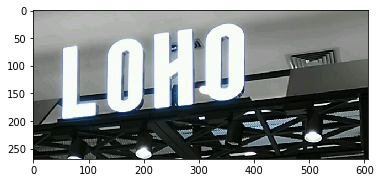

In [7]:
train_iter, val_iter, test_iter, n_class = loader.get_iter(labels)
for batch in train_iter:
    for x in batch[0]:
        loader.plot_image(x, transformType=None)
        break
    break

In [8]:
train_iter, val_iter, test_iter, n_class = loader.get_iter(labels)
ctx = xcv.try_gpu()
for batch in train_iter:
    X = nd.stack(*[loader.transform_train(x) for x in batch[0]]).as_in_context(ctx)
    Y = nd.array(batch[1], ctx=ctx)
    break

Populating the interactive namespace from numpy and matplotlib


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


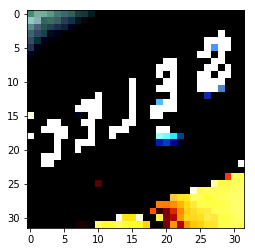

In [10]:
%pylab inline

x = nd.transpose(X[0], (1, 2, 0))
plt.imshow(x.asnumpy())
plt.show()

In [11]:
class X(nn.HybridBlock):
    '''
    此网络有两个输出
    '''
    def __init__(self, n_class, **kwargs):
        super().__init__(**kwargs)
        self.n_class = n_class
        self.features = get_model(
            'cifar_wideresnet40_8', classes=10, pretrained=True, ctx=ctx).features[:6]
        self.features.add(
            nn.BatchNorm(axis=1),
            nn.Activation(activation='relu'),
            nn.Conv2D(channels=256, kernel_size=1, padding=0),

            nn.BatchNorm(axis=1),
            nn.Conv2D(channels=self.n_class, kernel_size=1, padding=0))
        self.out = nn.HybridSequential()
        self.out.add(
            nn.GlobalAvgPool2D(),
            nn.Flatten())
        self.outimg = nn.HybridSequential()
        self.outimg.add(
            nn.BatchNorm(axis=1),
            nn.Conv2D(channels=50, kernel_size=1, padding=0),
            nn.Activation(activation='relu'),

            nn.BatchNorm(axis=1),
            nn.Conv2D(channels=3, kernel_size=1, padding=0),
        )

    def hybrid_forward(self, F, x):
        x = self.features(x)
        out = self.out(x)
        imgout = self.outimg(x)
        return out, imgout

In [12]:
net = X(n_class)

In [13]:
net.initialize(init=mx.init.MSRAPrelu(), ctx=ctx, force_reinit=True)
#net.hybridize()
trainer = gluon.Trainer(net.collect_params(), 'rmsprop',
                        {'learning_rate': 0.03, 'gamma1': 0.999})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


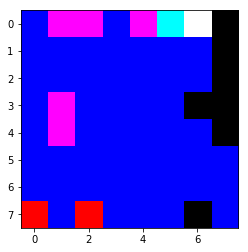

In [14]:
train_iter, val_iter, test_iter, n_class = loader.get_iter(labels)
ctx = xcv.try_gpu()
for batch in train_iter:
    X = nd.stack(*[loader.transform_train(x) for x in batch[0]]).as_in_context(ctx)
    out = net(X)
    Y = nd.array(batch[1], ctx=ctx)
    break
    
a = nd.transpose(out[1][0], (1, 2, 0))
plt.imshow(a.asnumpy())
plt.show()

In [24]:
train_iter, val_iter, test_iter, n_class = loader.get_iter(labels)
loader.test(net, val_iter, ctx)

('accuracy', 0.015596330275229359)